<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/chC_prob/prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probability


In this notebook, we illustrate some basic concepts from probability theory using Python code.




In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

import sklearn
import scipy.stats as stats
import scipy.optimize

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows



In [2]:
# https://github.com/google/jax
import jax
import jax.numpy as np
import numpy as onp # original numpy
from jax.scipy.special import logsumexp
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))

jax version 0.2.7


# Probability distributions  <a class="anchor" id="probdist"></a>

There are several software libraries that implement standard probability distributions, and functions for manipulating them (e.g., sampling, fitting). We list some below.


* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)  We illustrate how to use this below.

* [Tensorflow distributions library](https://www.tensorflow.org/api_docs/python/tf/distributions)
Similar API to scipy.stats.

* [Pytorch distributions library](https://pytorch.org/docs/stable/distributions.html). Similar API to Tensorflow.

* [JAX stats library](https://github.com/google/jax/tree/master/jax/scipy/stats). A partial re-implementation of scipy.stats. However, it is currently very limited in its coverage.

* [NumPyro distributions library](https://numpyro.readthedocs.io/en/latest/distributions.html) has a similar interface to PyTorch distributions, but uses JAX as the backend.
 
 
In this notebook, we mostly focus on scipy.stats.

## Univariate Gaussian (normal)  <a class="anchor" id="scipy-unigauss"></a>


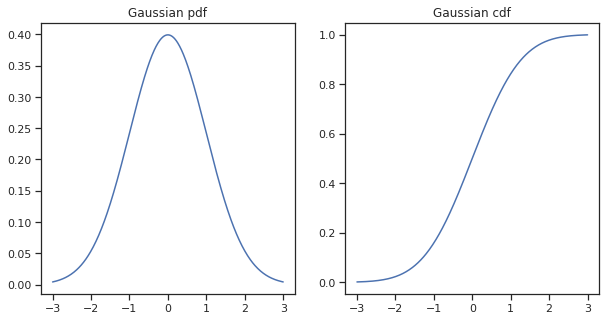

In [3]:
from scipy.stats import norm 

rv = norm(0, 1) # standard normal

fig, ax = plt.subplots(1,2, figsize=(10,5))
X = np.linspace(-3, 3, 500)
ax[0].plot(X, rv.pdf(X))
ax[0].set_title("Gaussian pdf")
ax[1].plot(X, rv.cdf(X))
ax[1].set_title("Gaussian cdf")
plt.show()


In [4]:
# Samples

onp.random.seed(42)
mu = 1.1
sigma = 0.1
dist = norm(loc=mu, scale=sigma) # create "frozen" distribution
N = 10
x = dist.rvs(size=N) # draw N random samples
print(x.shape)
print(x)

onp.random.seed(42)
x2 = norm(mu, sigma).rvs(size=N)
assert np.allclose(x, x2)



(10,)
[1.15  1.086 1.165 1.252 1.077 1.077 1.258 1.177 1.053 1.154]


In [5]:
# pdf, cdf, inverse cdf

logprob = dist.logpdf(x) # evaluate log probability of each sample
print(logprob.shape)

p = dist.cdf(x)
x3 = dist.ppf(p) # inverse CDF
assert np.allclose(x, x3)

(10,)


## Multivariate Gaussian (normal)  <a class="anchor" id="scipy-multigauss"></a>

In [6]:
from scipy.stats import multivariate_normal as mvn

D = 5
onp.random.seed(42)
mu = onp.random.randn(D)
A = onp.random.randn(D,D)
Sigma = np.dot(A, A.T)

dist = mvn(mu, Sigma)
X = dist.rvs(size=10)
print(X.shape) 

(10, 5)


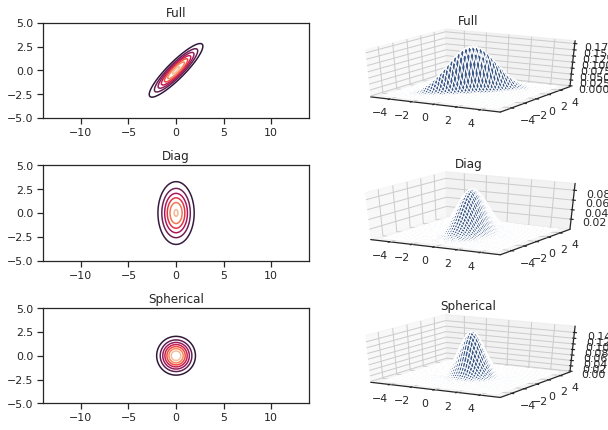

In [7]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

names = ["Full", "Diag", "Spherical"]

mu = [0, 0]
Covs = {'Full': [[2, 1.8], [1.8, 2]],
        'Diag': [[1, 0], [0, 3]],
        'Spherical': [[1, 0], [0, 1]]}

N = 100
points = np.linspace(-5, 5, N)
X, Y = np.meshgrid(points, points)
xs = X.reshape(-1)
ys = Y.reshape(-1)
grid = np.vstack([xs, ys]).T # N^2 * 2

fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
fig_counter = 1
for i in range(len(Covs)):
    name = names[i]
    Sigma = Covs[name]
    ps = mvn(mu, Sigma).pdf(grid)
    P = ps.reshape((N,N))

    ax = fig.add_subplot(3, 2, fig_counter)
    ax.contour(X, Y, P)
    ax.axis('equal') # make circles look circular
    ax.set_title(name)
    fig_counter = fig_counter + 1
    
    ax = fig.add_subplot(3, 2, fig_counter, projection='3d')
    ax.plot_surface(X, Y, P, rstride=2, cstride=2)
    ax.set_title(name)
    fig_counter = fig_counter + 1
plt.show()

Illustrate correlation coefficient.

Code is from [Bayesian Analysis with Python, ch. 3](https://github.com/aloctavodia/BAP/blob/master/code/Chp3/03_Modeling%20with%20Linear%20Regressions.ipynb)

Text(-0.05, 0.5, 'x_2')

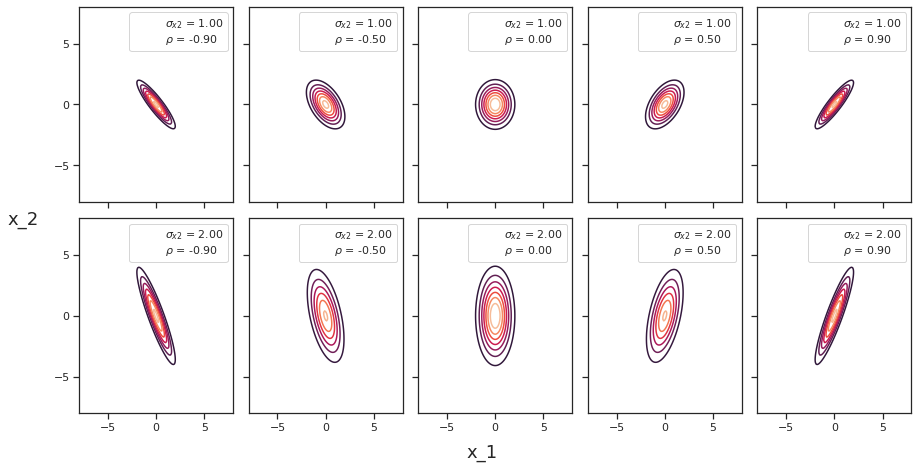

In [10]:

sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = onp.mgrid[-5:5:.1, -5:5:.1]
pos = onp.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

## Gamma distribution  <a class="anchor" id="scipy-gamma"></a>

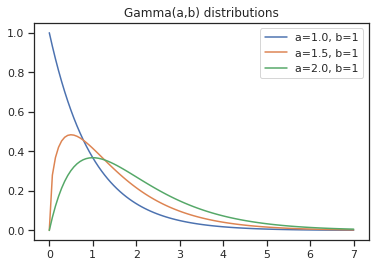

In [11]:
from scipy.stats import gamma

x = np.linspace(0, 7, 100)
b = 1
plt.figure()
for a in [1, 1.5, 2]:
    y = gamma.pdf(x, a, scale=1/b, loc=0)
    plt.plot(x, y)
plt.legend(['a=%.1f, b=1' % a for a in [1, 1.5, 2]])
plt.title('Gamma(a,b) distributions')
#save_fig('gammaDistb1.pdf')
plt.show()


# Zipf's law <a class="anchor" id="zipf"></a>

In this section, we study the empirical word frequencies derived from H. G. Wells' book [The time machine](https://en.wikipedia.org/wiki/The_Time_Machine).
Our code is based on https://github.com/d2l-ai/d2l-en/blob/master/chapter_recurrent-neural-networks/lang-model.md


In [12]:
import collections
import re
import urllib

url = 'https://raw.githubusercontent.com/probml/pyprobml/master/data/timemachine.txt' 
bytes = urllib.request.urlopen(url).read()
string = bytes.decode('utf-8')
words = string.split()
print(words[:10])
words = [re.sub('[^A-Za-z]+', ' ', w.lower()) for w in words]
print(words[:10])


['The', 'Time', 'Machine,', 'by', 'H.', 'G.', 'Wells', '[1898]', 'I', 'The']
['the', 'time', 'machine ', 'by', 'h ', 'g ', 'wells', ' ', 'i', 'the']


In [13]:
# Convert sequence of words into sequence of n-grams for different n

# Unigrams
wseq = words # [tk for st in raw_dataset for tk in st]
print('First 10 unigrams\n', wseq[:10])

# Bigrams
word_pairs = [pair for pair in zip(wseq[:-1], wseq[1:])]
print('First 10 bigrams\n', word_pairs[:10])

# Trigrams
word_triples = [triple for triple in zip(wseq[:-2], wseq[1:-1], wseq[2:])]
print('First 10 trigrams\n', word_triples[:10])

First 10 unigrams
 ['the', 'time', 'machine ', 'by', 'h ', 'g ', 'wells', ' ', 'i', 'the']
First 10 bigrams
 [('the', 'time'), ('time', 'machine '), ('machine ', 'by'), ('by', 'h '), ('h ', 'g '), ('g ', 'wells'), ('wells', ' '), (' ', 'i'), ('i', 'the'), ('the', 'time')]
First 10 trigrams
 [('the', 'time', 'machine '), ('time', 'machine ', 'by'), ('machine ', 'by', 'h '), ('by', 'h ', 'g '), ('h ', 'g ', 'wells'), ('g ', 'wells', ' '), ('wells', ' ', 'i'), (' ', 'i', 'the'), ('i', 'the', 'time'), ('the', 'time', 'traveller')]


In [ ]:
# ngram statistics

counter = collections.Counter(wseq)
counter_pairs = collections.Counter(word_pairs)
counter_triples = collections.Counter(word_triples)

wordcounts = [count for _,count in counter.most_common()]
bigramcounts = [count for _,count in counter_pairs.most_common()]
triplecounts = [count for _,count in counter_triples.most_common()]

print('Most common unigrams\n', counter.most_common(10))
print('Most common bigrams\n', counter_pairs.most_common(10))
print('Most common trigrams\n', counter_triples.most_common(10))

Most common unigrams
 [('the', 2232), ('and', 1197), ('i', 1176), ('of', 1147), ('a', 800), ('to', 671), ('was', 537), ('in', 535), ('my', 435), ('that', 404)]
Most common bigrams
 [(('of', 'the'), 309), (('in', 'the'), 168), (('i', 'had'), 127), (('and', 'the'), 109), (('i', 'was'), 107), (('the', 'time'), 93), (('it', 'was'), 88), (('to', 'the'), 85), (('of', 'a'), 71), (('as', 'i'), 70)]
Most common trigrams
 [(('the', 'time', 'traveller'), 32), (('the', 'time', 'traveller '), 20), (('the', 'time', 'machine '), 19), (('the', 'medical', 'man '), 17), (('it', 'seemed', 'to'), 15), (('i', 'did', 'not'), 14), (('i', 'began', 'to'), 13), (('it', 'was', 'a'), 13), (('said', 'the', 'time'), 12), (('out', 'of', 'the'), 12)]


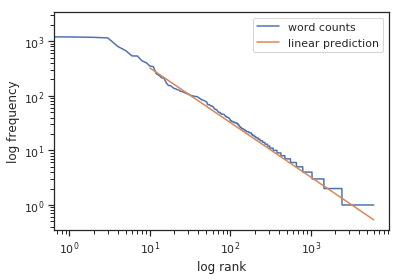

In [ ]:
# Word frequency is linear on log-log scale
plt.figure()
plt.loglog(wordcounts, label='word counts');
plt.ylabel('log frequency')
plt.xlabel('log rank')

# Prediction from Zipf's law, using manually chosen parameters.
# We omit the first 'skip' words, which don't fit the prediction well.
skip = 10.0
x = np.arange(skip, len(wordcounts)) 
N = np.sum(wordcounts)
kappa = 0.1
a = -1
y = kappa*np.power(x, a) * N # predicted frequency for word with rank x
plt.loglog(x, y, label='linear prediction')

plt.legend()
plt.show()


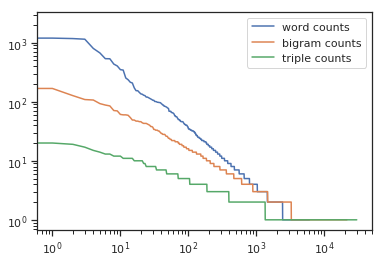

In [ ]:
# The number of unique n-grams is smaller for larger n.
# But n-gram statistics also exhibit a power law.

plt.figure()
plt.loglog(wordcounts, label='word counts');
plt.loglog(bigramcounts, label='bigram counts');
plt.loglog(triplecounts, label='triple counts');
plt.legend();
plt.show()
